## Create New Data

After talking with Jessica & Dan, we decided to try and label the Escondido pixels ourselves instead of relying on LANDFIRE labels which we have plenty of analysis to show is inaccurate.   The idea is to create clusters using K-Means, and then visually categorize each cluster according to the following generic categories:
*  Grass
* Scrub  (dry trees)
* Urban Forrest (wet trees)
* Urban
*  Water
* Barren
* Edge_Urban/Grass
* Edge_Urban/Scrub
* Edge_Urban/Urban Forrest

Pooja has already completed K-means clusters on 2014 Escondido pixels that were feature engineered using ResNet-50.  She performed the clustering using k=50 and k=100

In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.image as mpimg
import math
%matplotlib inline

In [4]:
K50=pd.read_table('clusters_50', sep=',')
print (K50.shape)
K50.columns=['Cluster','Image','LANDFIRE Label','DistFromClusterCenter']
K50["FileName"]=K50['Image'].apply(lambda x: x.split('/')[-1])
K50["FuelFileIndex"]=K50['FileName'].apply(lambda x: int(x.split('_')[3][3:]))
K50.head()

(146087, 4)


,Cluster,Image,LANDFIRE Label,DistFromClusterCenter,FileName,FuelFileIndex
0,13,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Urban,49,FuelTile_2014_Created18May2017_Idx0_91.jpg,0
1,13,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Short Grass,41,FuelTile_2014_Created18May2017_Idx1_1.jpg,1
2,23,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Short Grass,58,FuelTile_2014_Created18May2017_Idx2_1.jpg,2
3,22,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Urban,46,FuelTile_2014_Created18May2017_Idx3_91.jpg,3
4,20,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Urban,42,FuelTile_2014_Created18May2017_Idx4_91.jpg,4


In [5]:
Hold=[]
FilteredClusters={}
Excluded=[]
for c in K50["Cluster"].unique():
    A=K50[K50["Cluster"]==c]["DistFromClusterCenter"].describe()
    
    FilteredClusters[c]=K50[(K50["Cluster"]==c)&(K50["DistFromClusterCenter"]>=A[4]) & (K50["DistFromClusterCenter"]<=A[6])]
    Hold.append([c,A[1],A[2],A[4],A[5],A[6],A[0],FilteredClusters[c].shape[0]])
    Excluded.append(K50[(K50["Cluster"]==c)&((K50["DistFromClusterCenter"]<A[4]) | (K50["DistFromClusterCenter"]>A[6]))])
    
DistFromCenter=pd.DataFrame(Hold,columns=["Cluster","Mean","Std","25%","50%",'75%','ImagesInCluster','ImagesAfterFilter'])
NeedReCluster=pd.concat(Excluded)
DistFromCenter.head()

,Cluster,Mean,Std,25%,50%,75%,ImagesInCluster,ImagesAfterFilter
0,13,43.947062,7.004692,39.0,43.0,48.0,2059.0,1165
1,23,42.131629,6.197958,38.0,42.0,46.0,2112.0,1160
2,22,44.648307,6.920083,40.0,44.0,49.0,2215.0,1180
3,20,42.495389,6.080443,38.0,42.0,46.0,1952.0,1107
4,46,42.961619,6.438954,38.0,42.0,47.0,2397.0,1382


In [6]:
print ('Total Images:', K50.shape[0])
print('Total Included in these Clusters: ',DistFromCenter["ImagesAfterFilter"].sum())
print ('Total Removed for ReClustering: ',NeedReCluster.shape[0])
NeedReCluster.head()

Total Images: 146087
Total Included in these Clusters:  81788
Total Removed for ReClustering:  64299


,Cluster,Image,LANDFIRE Label,DistFromClusterCenter,FileName,FuelFileIndex
0,13,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Urban,49,FuelTile_2014_Created18May2017_Idx0_91.jpg,0
17,13,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Urban,34,FuelTile_2014_Created18May2017_Idx17_91.jpg,17
26,13,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Urban,29,FuelTile_2014_Created18May2017_Idx26_91.jpg,26
232,13,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Urban,51,FuelTile_2014_Created18May2017_Idx232_91.jpg,232
294,13,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Urban,37,FuelTile_2014_Created18May2017_Idx294_91.jpg,294


In [7]:
# Re-Cluster:
from sklearn.cluster import KMeans

## Get Data
data = np.loadtxt("WIFIRE/ResNet50_Analysis/WIFIRE_Engineered/WIFIRE_engineered_features_new.csv",delimiter=",")

In [7]:
# Get those we just excluded
Ind=NeedReCluster["FuelFileIndex"].tolist()
Data=data[Ind]

# Run kmeans clustering on image_tiles and save clusters into tile_cluster dataframe           
kmeans = KMeans(n_clusters=50, init='k-means++',n_init=50,random_state=0, n_jobs=10)
kmeans.fit(Data)
tile_clusters = pd.DataFrame(kmeans.labels_,columns=['Cluster']).sort_values('Cluster')
    
##Transform to get distance of data point from each cluster
distance = pd.DataFrame(kmeans.transform(Data))

## Merge clusters with distance:
tile_clusters['Distance'] = distance.loc[:,:].min(axis=1).astype(int)

KeyboardInterrupt: 

In [53]:
tile_clusters.head()

,Cluster,Distance
41052,0,15
40717,0,14
40718,0,17
40719,0,15
40721,0,24


In [7]:
tile_clusters['Index']=tile_clusters.index

NameError: name 'tile_clusters' is not defined

In [ ]:
print (tile_clusters.shape)
NewK50=pd.merge(tile_clusters,K50[['Image','LANDFIRE Label','FuelFileIndex']],left_on='Index',right_on='FuelFileIndex',how='left')
print (NewK50.shape)
NewK50.head()

In [60]:
#Export for Pooja's visualization
NewK50[["Cluster","Image","LANDFIRE Label","Distance"]].to_csv('clusters_50_ReDoCluster.csv',index=False)

In [31]:
# According to Dan these look totally random: 
Hold=[]
IndClus={}
for c in NewK50["Cluster"].unique():
    A=NewK50[NewK50["Cluster"]==c]["DistFromClusterCenter"].describe()
    
    IndClus[c]=NewK50[NewK50["Cluster"]==c]
    Hold.append([c,A[1],A[2],A[4],A[5],A[6],A[0]])
    
    
DistFromCenter_IT2=pd.DataFrame(Hold,columns=["Cluster","Mean","Std","25%","50%",'75%','ImagesInCluster','ImagesAfterFilter'])
DistFromCenter_IT2.head()

NameError: name 'NewK50' is not defined

In [ ]:
IndClus[0].boxplot("Distance")

MemoryError: 

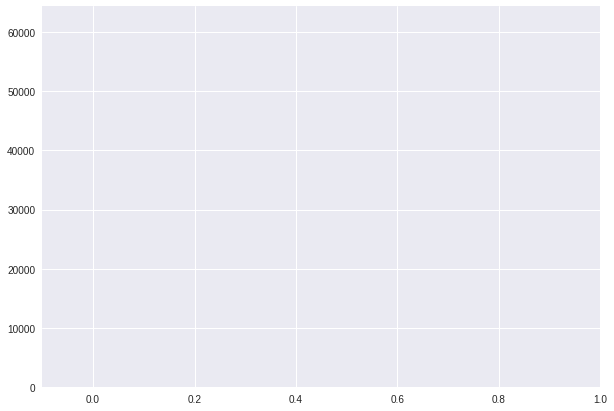

In [12]:
# Let's try clustering these again but this time be more strategic with our clusters
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
Ind=NeedReCluster["FuelFileIndex"].tolist()
X=data[Ind]
range_n_clusters = range(10,100,10)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(10, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()

In [ ]:
# Let's try clustering these again, but this time let's look for optimal clusters
from sklearn.metrics import silhouette_score

s = []
for n_clusters in range(10,100,10):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(Data)

    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    s.append(silhouette_score(dt_trans, labels, metric='euclidean'))

plt.plot(s)
plt.ylabel("Silouette")
plt.xlabel("k")
plt.title("Silouette for K-means cell's behaviour")

In [32]:
#Try clustering with K=80
Ind=NeedReCluster["FuelFileIndex"].tolist()
Data=data[Ind]

# Run kmeans clustering on image_tiles and save clusters into tile_cluster dataframe           
kmeans = KMeans(n_clusters=80, init='k-means++',n_init=50,random_state=0, n_jobs=10)
kmeans.fit(Data)
tile_clusters = pd.DataFrame(kmeans.labels_,columns=['Cluster']).sort_values('Cluster')
    
##Transform to get distance of data point from each cluster
distance = pd.DataFrame(kmeans.transform(Data))

## Merge clusters with distance:
tile_clusters['Distance'] = distance.loc[:,:].min(axis=1).astype(int)

#Output
tile_clusters['Index']=tile_clusters.index
print (tile_clusters.shape)
NewK80=pd.merge(tile_clusters,K50[['Image','LANDFIRE Label','FuelFileIndex']],left_on='Index',right_on='FuelFileIndex',how='left')
print (NewK80.shape)

#Export for Pooja's visualization
NewK80[["Cluster","Image","LANDFIRE Label","Distance"]].to_csv('clusters_50_ReDoClusterK80.csv',index=False)
NewK80.head()

KeyboardInterrupt: 

In [8]:
#For the first iteration, Pooja, Jessica, Dan and I decided on the labels
K50_Filtered_Labels=pd.read_csv('WIFIRE/Cluster50_Iteration1.csv')
K50_Filtered_Labels=K50_Filtered_Labels.iloc[0:50]
K50_Filtered_Labels["Cluster"]=K50_Filtered_Labels["Cluster"].apply(lambda x: int(x))
K50_Filtered_Labels.head()

,Cluster,Label,TeamAgree
0,0,B,False
1,1,S,True
2,2,U,True
3,3,S,False
4,4,U,True


In [9]:
It1Data=pd.DataFrame()
for index,row in K50_Filtered_Labels.iterrows():
    A=FilteredClusters[row["Cluster"]].copy()
    A["NewLabel"]=row["Label"]
    It1Data=pd.concat([It1Data,A])
print (It1Data.shape)
It1Data.head()

(81788, 7)


,Cluster,Image,LANDFIRE Label,DistFromClusterCenter,FileName,FuelFileIndex,NewLabel
90,0,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Short Grass,39,FuelTile_2014_Created18May2017_Idx90_1.jpg,90,B
104,0,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Urban,42,FuelTile_2014_Created18May2017_Idx104_91.jpg,104,B
202,0,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Short Grass,41,FuelTile_2014_Created18May2017_Idx202_1.jpg,202,B
378,0,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Urban,43,FuelTile_2014_Created18May2017_Idx378_91.jpg,378,B
409,0,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Timber Grass,34,FuelTile_2014_Created18May2017_Idx409_2.jpg,409,B


In [27]:
# Use new Data in Spiral 1 model:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import normalize
df=data[It1Data["FuelFileIndex"].tolist()]
labels=It1Data["NewLabel"].tolist()

n_samples = len(df)
X = normalize(df)
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
sgd = SGDClassifier(n_jobs=-1, random_state=0)
parameters =  {'loss':('hinge',)}        
classifier = GridSearchCV(sgd, parameters, cv=5)
classifier.fit(X_train, y_train)
predict_target = classifier.predict(X_test)

In [28]:
((np.sum([y_test == predict_target])*1.0)/(len(y_test)*1.0))*100

85.670619880180951

In [30]:
classifier.score(X_test,y_test)

0.85670619880180954

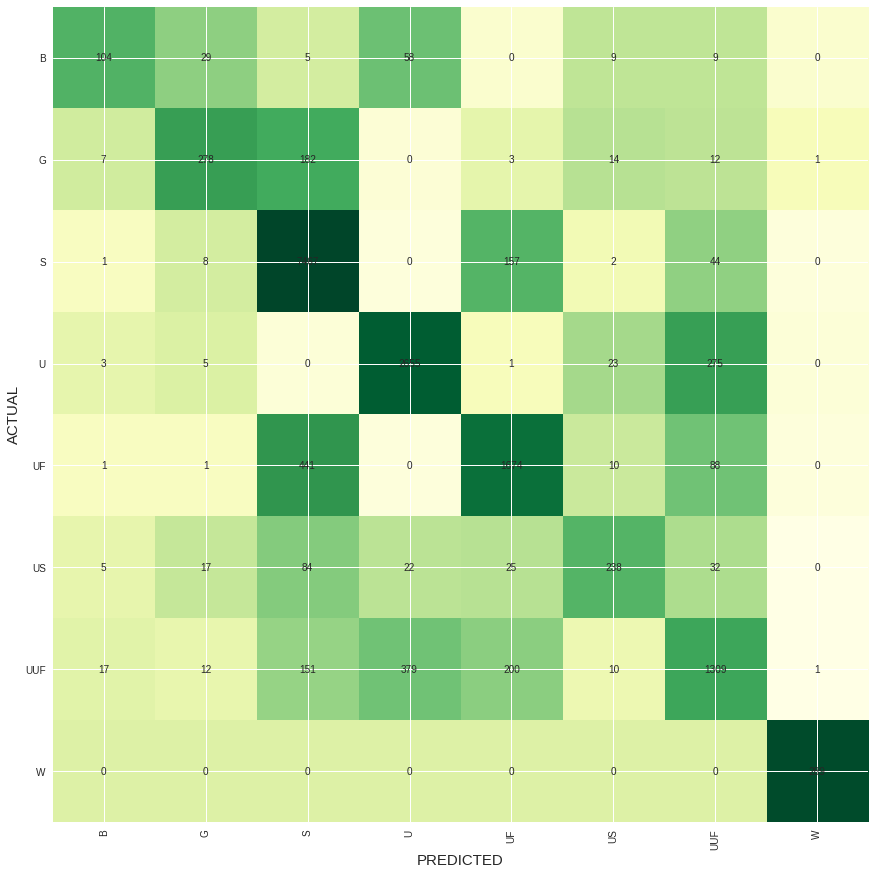

In [29]:
#confusion matrix
conf_arr = confusion_matrix(y_test, predict_target)
log_conf_arr = np.log((conf_arr+1)*10000) #For better color choice
norm_conf = []
for i in log_conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)
    
fig = plt.figure(figsize = (15,15))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.YlGn, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)
alphabet = np.unique(y_test)
plt.xticks(range(width), alphabet[:width], rotation='vertical')
plt.yticks(range(height), alphabet[:height])
plt.xlabel('PREDICTED', fontsize=15)
plt.ylabel('ACTUAL', fontsize=15)


In [10]:
#We have reclustered the "outliers" using K=30
OutliersK30_Labels=pd.read_csv('WIFIRE/Cluster50_Outliers_K30.csv')
OutliersK30_Labels=OutliersK30_Labels.iloc[0:30]
OutliersK30_Labels["Cluster"]=OutliersK30_Labels["Cluster"].apply(lambda x: int(x))
OutliersK30_Labels.head()

OutlierK30=pd.read_table('cluster50_outliers_cluster30', sep=',')
print (OutlierK30.shape)
OutlierK30.columns=['Cluster','Image','LANDFIRE Label','DistFromClusterCenter']
OutlierK30["FileName"]=OutlierK30['Image'].apply(lambda x: x.split('/')[-1])
OutlierK30["FuelFileIndex"]=OutlierK30['FileName'].apply(lambda x: int(x.split('_')[3][3:]))
OutlierK30.head()

(64299, 4)


,Cluster,Image,LANDFIRE Label,DistFromClusterCenter,FileName,FuelFileIndex
0,16,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Urban,52,FuelTile_2014_Created18May2017_Idx0_91.jpg,0
1,15,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Short Grass,57,FuelTile_2014_Created18May2017_Idx2_1.jpg,2
2,8,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Timber Grass,34,FuelTile_2014_Created18May2017_Idx5_2.jpg,5
3,17,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Urban,49,FuelTile_2014_Created18May2017_Idx8_91.jpg,8
4,15,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Urban,40,FuelTile_2014_Created18May2017_Idx10_91.jpg,10


In [11]:
def AddNewLabel(cluster):
    return OutliersK30_Labels[OutliersK30_Labels["Cluster"]==cluster]["Label_PM"].values[0]

OutlierK30["NewLabel"]=OutlierK30["Cluster"].apply(lambda x: AddNewLabel(x))
OutlierK30.head()


,Cluster,Image,LANDFIRE Label,DistFromClusterCenter,FileName,FuelFileIndex,NewLabel
0,16,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Urban,52,FuelTile_2014_Created18May2017_Idx0_91.jpg,0,U
1,15,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Short Grass,57,FuelTile_2014_Created18May2017_Idx2_1.jpg,2,U
2,8,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Timber Grass,34,FuelTile_2014_Created18May2017_Idx5_2.jpg,5,UUF
3,17,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Urban,49,FuelTile_2014_Created18May2017_Idx8_91.jpg,8,U
4,15,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Urban,40,FuelTile_2014_Created18May2017_Idx10_91.jpg,10,U


In [12]:
AllNewData=pd.concat([It1Data[["Image","FuelFileIndex","NewLabel"]],OutlierK30[["Image","FuelFileIndex","NewLabel"]]])
print (AllNewData.shape)
#AllNewData.to_csv('AllNewData.csv',index=False)

(146087, 3)


In [24]:
# Let's run it all through spiral 1

from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import normalize
df=data[AllNewData["FuelFileIndex"].tolist()]
labels=AllNewData["NewLabel"].tolist()
n_samples = len(df)
X = normalize(df)
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
sgd = SGDClassifier(n_jobs=-1, random_state=0)
parameters =  {'loss':('hinge',)}        
classifier = GridSearchCV(sgd, parameters, cv=5)
classifier.fit(X_train, y_train)
predict_target = classifier.predict(X_test)
classifier.score(X_test,y_test)

0.81805736190019851

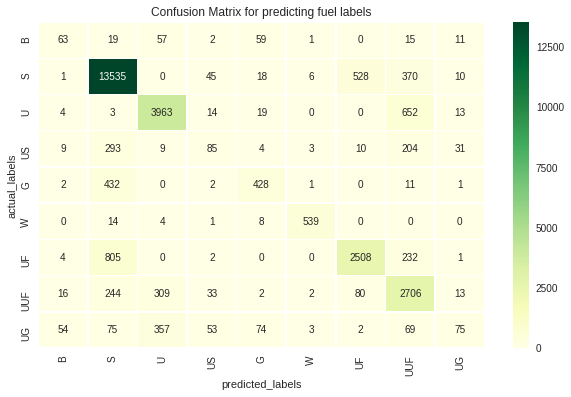

In [25]:
def plot_cm(cm, labels):
    df = pd.DataFrame()
    for i, row_label in enumerate(labels):
        rowdata={}
        for j, col_label in enumerate(labels):
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    fig = plt.figure(figsize = (10,6))
    ax = sns.heatmap(df[labels], annot=True,fmt="d", linewidths=.5,cmap = "YlGn")
    plt.title("Confusion Matrix for predicting fuel labels")
    plt.xlabel('predicted_labels')
    plt.ylabel('actual_labels')
    plt.xticks(rotation = 'vertical')
    
labels = list(AllNewData["NewLabel"].unique())
cm = confusion_matrix(y_test, predict_target, labels)
plot_cm(cm,labels)

In [26]:
AllNewData["NewLabel"].value_counts()

S      72538
U      23281
UUF    17327
UF     17260
G       4592
UG      3859
US      3241
W       2862
B       1127
Name: NewLabel, dtype: int64

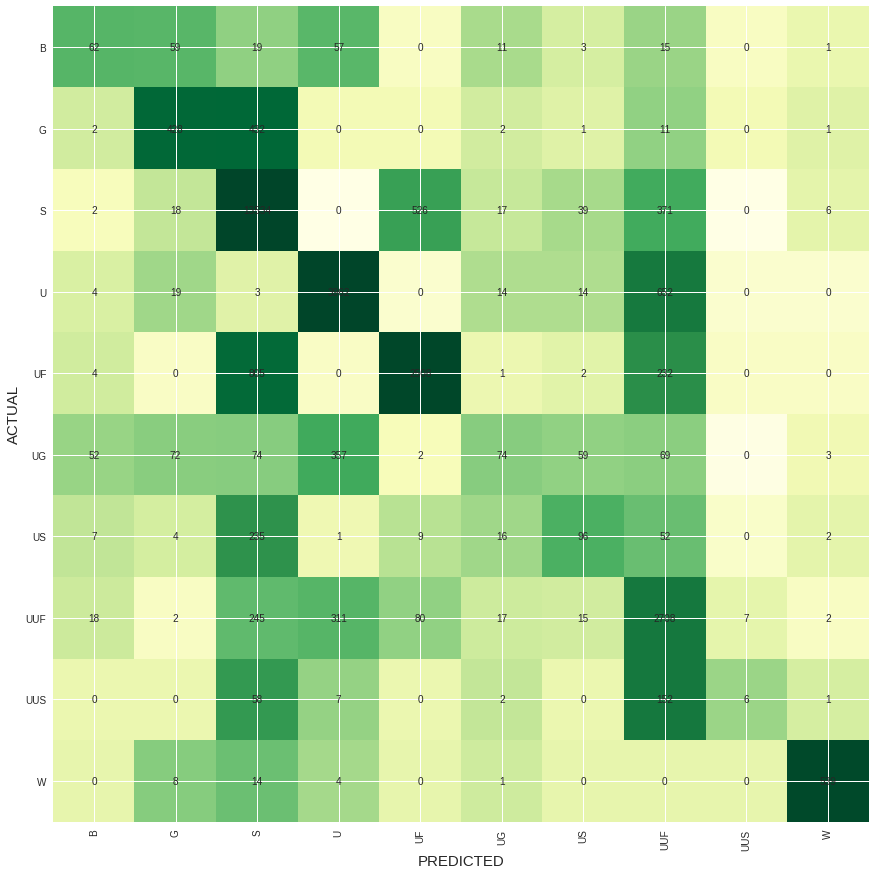

In [56]:
#confusion matrix
conf_arr = confusion_matrix(y_test, predict_target)
log_conf_arr = np.log((conf_arr+1)*10000) #For better color choice
norm_conf = []
for i in log_conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)
    
fig = plt.figure(figsize = (15,15))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.YlGn, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)
alphabet = np.unique(y_test)
plt.xticks(range(width), alphabet[:width], rotation='vertical')
plt.yticks(range(height), alphabet[:height])
plt.xlabel('PREDICTED', fontsize=15)
plt.ylabel('ACTUAL', fontsize=15)

In [28]:
#What about using a random forrest?
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier()
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.82230132110342935

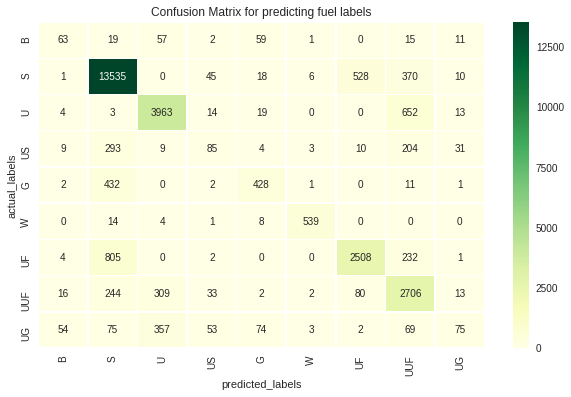

In [29]:
predict_target = classifier.predict(X_test)
labels = list(AllNewData["NewLabel"].unique())
cm = confusion_matrix(y_test, predict_target, labels)
plot_cm(cm,labels)

Want to  see those pixels that were Misclassified

In [13]:
AllNewData=pd.read_csv('AllNewData.csv')

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import normalize

# According to Sadat,  the optimal parameters for SGD are: {'loss': 'hinge', 'n_iter': 7, 'penalty': 'none'}
df=data[AllNewData["FuelFileIndex"].tolist()]
labels=AllNewData[["NewLabel","FuelFileIndex"]].values
n_samples = len(df)
X = normalize(df)
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [47]:
y_test[:,0]

array(['S', 'UUF', 'S', ..., 'U', 'U', 'UUF'], dtype=object)

In [16]:
sgd = SGDClassifier(loss='hinge',n_iter=7,penalty='none')
sgd.fit(X_train, y_train[:,0])
predict_target = sgd.predict(X_test)
sgd.score(X_test,y_test[:,0])

0.82962557327674724

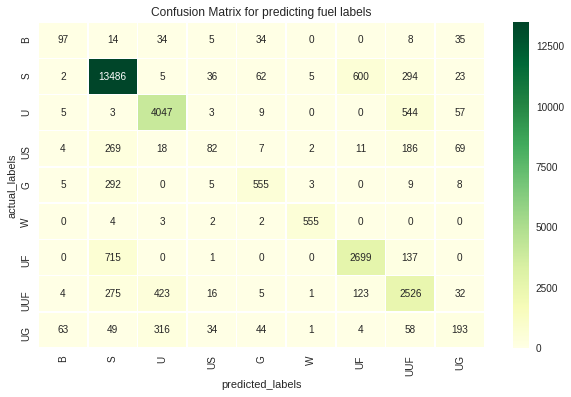

In [17]:
def plot_cm(cm, labels):
    df = pd.DataFrame()
    for i, row_label in enumerate(labels):
        rowdata={}
        for j, col_label in enumerate(labels):
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    fig = plt.figure(figsize = (10,6))
    ax = sns.heatmap(df[labels], annot=True,fmt="d", linewidths=.5,cmap = "YlGn")
    plt.title("Confusion Matrix for predicting fuel labels")
    plt.xlabel('predicted_labels')
    plt.ylabel('actual_labels')
    plt.xticks(rotation = 'vertical')
    
labels = list(AllNewData["NewLabel"].unique())
cm = confusion_matrix(y_test[:,0], predict_target, labels)
plot_cm(cm,labels)

In [18]:
Viz=AllNewData.ix[y_test[:,1]].copy()
Viz["Predicted"]=y_test[:,0]
Viz[Viz["NewLabel"]!=Viz["Predicted"]].shape[0]

20637

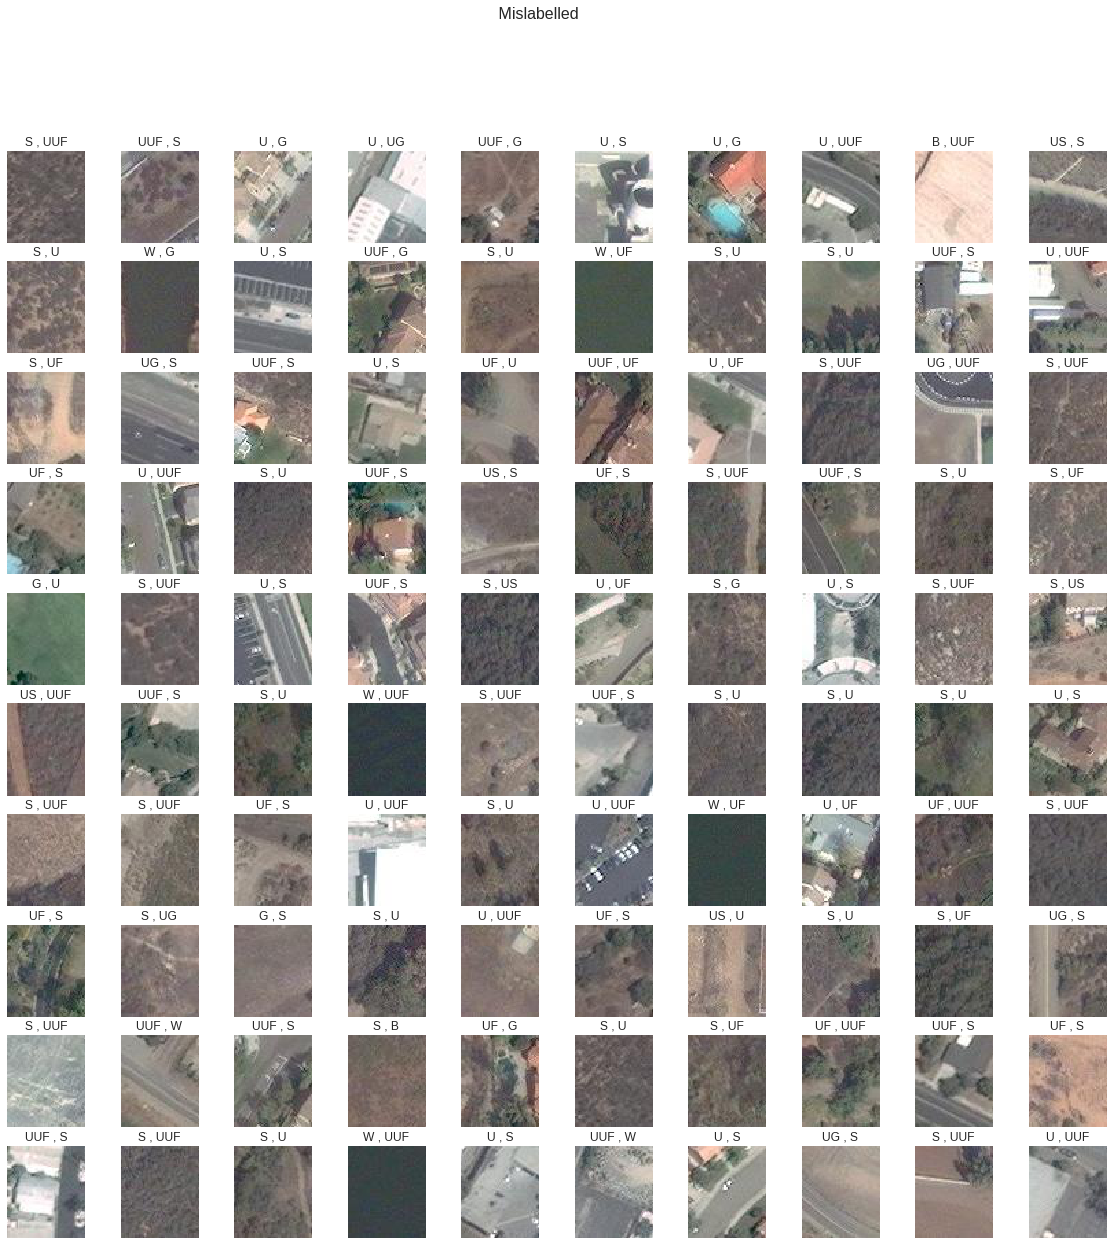

In [20]:


fig = plt.figure(figsize=(20,20))
fig.suptitle(" Mislabelled ", fontsize= 16)
fig.subplots_adjust() 
j=0
#v=math.ceil(math.sqrt(Viz[Viz["NewLabel"]!=Viz["Predicted"]].shape[0]))
v=10
for index,row in Viz[Viz["NewLabel"]!=Viz["Predicted"]].head(100).iterrows():
    ax = fig.add_subplot(v,v,j+1, xticks=[], yticks=[])
    image = mpimg.imread(row["Image"])      
    ax.imshow(image)
    ax.set_title(row["NewLabel"]+" , "+row["Predicted"])
    j+=1

There were a couple of clusters that could be considered "Agriculture".  Let's see if including that category makes a difference:
* Cluster K=50: 37, 44, 
* Outliers K=30: 1

In [19]:
K50_Filtered_Labels_Ag=K50_Filtered_Labels.copy()
idx=K50_Filtered_Labels_Ag[(K50_Filtered_Labels_Ag["Cluster"]==37) | (K50_Filtered_Labels_Ag["Cluster"]==44)].index
K50_Filtered_Labels_Ag["Label"].ix[idx]='A'


/opt/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [21]:
It1Data=pd.DataFrame()
for index,row in K50_Filtered_Labels_Ag.iterrows():
    A=FilteredClusters[row["Cluster"]].copy()
    A["NewLabel"]=row["Label"]
    It1Data=pd.concat([It1Data,A])
print (It1Data.shape)
It1Data.head()

(81788, 7)


,Cluster,Image,LANDFIRE Label,DistFromClusterCenter,FileName,FuelFileIndex,NewLabel
90,0,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Short Grass,39,FuelTile_2014_Created18May2017_Idx90_1.jpg,90,B
104,0,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Urban,42,FuelTile_2014_Created18May2017_Idx104_91.jpg,104,B
202,0,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Short Grass,41,FuelTile_2014_Created18May2017_Idx202_1.jpg,202,B
378,0,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Urban,43,FuelTile_2014_Created18May2017_Idx378_91.jpg,378,B
409,0,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Timber Grass,34,FuelTile_2014_Created18May2017_Idx409_2.jpg,409,B


In [31]:
#"outliers" using K=30
OutliersK30_Labels=pd.read_csv('WIFIRE/Cluster50_Outliers_K30.csv')
OutliersK30_Labels=OutliersK30_Labels.iloc[0:30]
OutliersK30_Labels["Cluster"]=OutliersK30_Labels["Cluster"].apply(lambda x: int(x))
idx=OutliersK30_Labels[OutliersK30_Labels["Cluster"]==1].index
OutliersK30_Labels["Label_PM"].ix[idx]='A'

OutlierK30=pd.read_table('cluster50_outliers_cluster30', sep=',')
print (OutlierK30.shape)
OutlierK30.columns=['Cluster','Image','LANDFIRE Label','DistFromClusterCenter']
OutlierK30["FileName"]=OutlierK30['Image'].apply(lambda x: x.split('/')[-1])
OutlierK30["FuelFileIndex"]=OutlierK30['FileName'].apply(lambda x: int(x.split('_')[3][3:]))
OutlierK30.head()

/opt/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


(64299, 4)


,Cluster,Image,LANDFIRE Label,DistFromClusterCenter,FileName,FuelFileIndex
0,16,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Urban,52,FuelTile_2014_Created18May2017_Idx0_91.jpg,0
1,15,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Short Grass,57,FuelTile_2014_Created18May2017_Idx2_1.jpg,2
2,8,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Timber Grass,34,FuelTile_2014_Created18May2017_Idx5_2.jpg,5
3,17,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Urban,49,FuelTile_2014_Created18May2017_Idx8_91.jpg,8
4,15,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Urban,40,FuelTile_2014_Created18May2017_Idx10_91.jpg,10


In [32]:
def AddNewLabel(cluster):
    return OutliersK30_Labels[OutliersK30_Labels["Cluster"]==cluster]["Label_PM"].values[0]

OutlierK30["NewLabel"]=OutlierK30["Cluster"].apply(lambda x: AddNewLabel(x))
OutlierK30.head()

,Cluster,Image,LANDFIRE Label,DistFromClusterCenter,FileName,FuelFileIndex,NewLabel
0,16,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Urban,52,FuelTile_2014_Created18May2017_Idx0_91.jpg,0,U
1,15,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Short Grass,57,FuelTile_2014_Created18May2017_Idx2_1.jpg,2,U
2,8,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Timber Grass,34,FuelTile_2014_Created18May2017_Idx5_2.jpg,5,UUF
3,17,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Urban,49,FuelTile_2014_Created18May2017_Idx8_91.jpg,8,U
4,15,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Urban,40,FuelTile_2014_Created18May2017_Idx10_91.jpg,10,U


In [33]:
AllNewData=pd.concat([It1Data[["Image","FuelFileIndex","NewLabel"]],OutlierK30[["Image","FuelFileIndex","NewLabel"]]])
print (AllNewData.shape)

(146087, 3)


In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import normalize
df=data[AllNewData["FuelFileIndex"].tolist()]
labels=AllNewData["NewLabel"].tolist()
n_samples = len(df)
X = normalize(df)
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
sgd = SGDClassifier(n_jobs=-1, random_state=0)
parameters =  {'loss':('hinge',)}        
classifier = GridSearchCV(sgd, parameters, cv=5)
classifier.fit(X_train, y_train)
predict_target = classifier.predict(X_test)
classifier.score(X_test,y_test)

0.81562735300157441

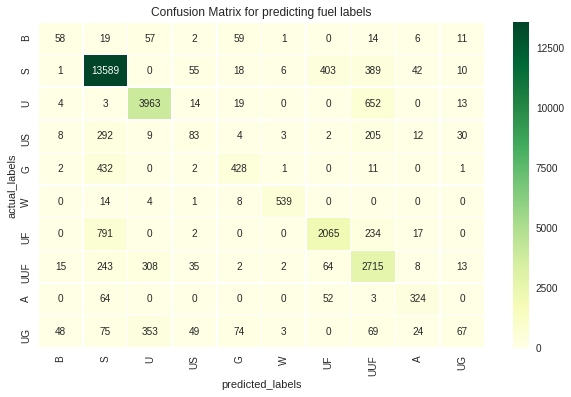

In [35]:
def plot_cm(cm, labels):
    df = pd.DataFrame()
    for i, row_label in enumerate(labels):
        rowdata={}
        for j, col_label in enumerate(labels):
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    fig = plt.figure(figsize = (10,6))
    ax = sns.heatmap(df[labels], annot=True,fmt="d", linewidths=.5,cmap = "YlGn")
    plt.title("Confusion Matrix for predicting fuel labels")
    plt.xlabel('predicted_labels')
    plt.ylabel('actual_labels')
    plt.xticks(rotation = 'vertical')
    
labels = list(AllNewData["NewLabel"].unique())
cm = confusion_matrix(y_test, predict_target, labels)
plot_cm(cm,labels)

Looks like "Agriculture"  category will not  help

What if we did a third iteration?

In [21]:
OutlierK30=pd.read_table('cluster50_outliers_cluster30', sep=',')
print (OutlierK30.shape)
OutlierK30.columns=['Cluster','Image','LANDFIRE Label','DistFromClusterCenter']
OutlierK30["FileName"]=OutlierK30['Image'].apply(lambda x: x.split('/')[-1])
OutlierK30["FuelFileIndex"]=OutlierK30['FileName'].apply(lambda x: int(x.split('_')[3][3:]))
OutlierK30.head()

(64299, 4)


,Cluster,Image,LANDFIRE Label,DistFromClusterCenter,FileName,FuelFileIndex
0,16,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Urban,52,FuelTile_2014_Created18May2017_Idx0_91.jpg,0
1,15,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Short Grass,57,FuelTile_2014_Created18May2017_Idx2_1.jpg,2
2,8,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Timber Grass,34,FuelTile_2014_Created18May2017_Idx5_2.jpg,5
3,17,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Urban,49,FuelTile_2014_Created18May2017_Idx8_91.jpg,8
4,15,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Urban,40,FuelTile_2014_Created18May2017_Idx10_91.jpg,10


In [22]:
Hold=[]
FilteredClustersIt2={}
Excluded=[]
for c in OutlierK30["Cluster"].unique():
    A=OutlierK30[OutlierK30["Cluster"]==c]["DistFromClusterCenter"].describe()
    
    FilteredClustersIt2[c]=OutlierK30[(OutlierK30["Cluster"]==c)&(OutlierK30["DistFromClusterCenter"]>=A[4]) & (OutlierK30["DistFromClusterCenter"]<=A[6])]
    Hold.append([c,A[1],A[2],A[4],A[5],A[6],A[0],FilteredClustersIt2[c].shape[0]])
    Excluded.append(OutlierK30[(OutlierK30["Cluster"]==c)&((OutlierK30["DistFromClusterCenter"]<A[4]) | (OutlierK30["DistFromClusterCenter"]>A[6]))])
    
DistFromCenter=pd.DataFrame(Hold,columns=["Cluster","Mean","Std","25%","50%",'75%','ImagesInCluster','ImagesAfterFilter'])
NeedReClusterIt2=pd.concat(Excluded)
DistFromCenter.head()

,Cluster,Mean,Std,25%,50%,75%,ImagesInCluster,ImagesAfterFilter
0,16,46.264879,9.728706,37.0,48.0,54.0,1529.0,901
1,15,44.525726,9.007807,37.0,41.0,52.0,1516.0,850
2,8,45.153675,8.563945,37.0,47.0,51.0,1347.0,696
3,17,45.199044,9.109078,37.0,47.0,52.0,1673.0,908
4,4,45.472352,9.298567,37.0,48.0,53.0,1067.0,586


In [23]:
#Try clustering with K=15
Ind=NeedReClusterIt2["FuelFileIndex"].tolist()
Data=data[Ind]

# Run kmeans clustering on image_tiles and save clusters into tile_cluster dataframe           
kmeans = KMeans(n_clusters=15, init='k-means++',n_init=50,random_state=0, n_jobs=10)
kmeans.fit(Data)
tile_clusters = pd.DataFrame(kmeans.labels_,columns=['Cluster']).sort_values('Cluster')
    
##Transform to get distance of data point from each cluster
distance = pd.DataFrame(kmeans.transform(Data))

## Merge clusters with distance:
tile_clusters['Distance'] = distance.loc[:,:].min(axis=1).astype(int)

#Output
tile_clusters['Index']=tile_clusters.index
print (tile_clusters.shape)
NewK15=pd.merge(tile_clusters,OutlierK30[['Image','LANDFIRE Label','FuelFileIndex']],left_on='Index',right_on='FuelFileIndex',how='left')
print (NewK15.shape)


(28512, 3)
(28512, 6)


In [24]:
#Export for Pooja's visualization
NewK15[["Image","Cluster","Distance"]].to_csv('clusters_50_ReDoClusterK30_ReDoK15.csv',index=False)
NewK15.head()

,Cluster,Distance,Index,Image,LANDFIRE Label,FuelFileIndex
0,0,44,9158,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Timber Grass,9158.0
1,0,36,15976,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Short Grass,15976.0
2,0,38,15975,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Short Grass,15975.0
3,0,37,15974,NaN,NaN,NaN
4,0,36,15973,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,Timber Grass,15973.0


In [34]:
import montage_manager
M = montage_manager.Montages()
img_hist = M.create_image_hist(src_path= 'clusters_50_ReDoClusterK30_ReDoK15.csv')
img_hist.save("Outlier_It2.png")

AttributeError: 'str' object has no attribute 'read'